In [1]:
# !pip install roboflow



In [2]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    def __init__(self, root_dir, feature_extractor):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        
        # Читаем _classes.csv
        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            lines = fid.readlines()
            data = [line.strip().split(',') for line in lines[1:]]  # Пропускаем заголовок
            self.id2label = {str(id_): name for id_, name in data}
        
        # Собираем файлы
        image_file_names = [f for f in os.listdir(self.root_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
        mask_file_names = [f for f in os.listdir(self.root_dir) if f.lower().endswith('.png')]
        
        # Извлекаем базовые имена, убирая суффикс _mask из масок
        image_bases = {f.replace('.jpg', '').replace('.jpeg', '') for f in image_file_names}
        mask_bases = {f.replace('_mask.png', '').replace('.png', '') for f in mask_file_names}
        
        # Находим общие базовые имена
        common_bases = sorted(image_bases & mask_bases)
        self.images = [f"{base}.jpg" for base in common_bases]  # Предполагаем .jpg, можно добавить .jpeg
        self.masks = [f"{base}_mask.png" for base in common_bases]  # Добавляем _mask для масок
        
        print(f"Images: {len(self.images)}, Masks: {len(self.masks)}")
        print(f"First 5 images: {self.images[:5]}")
        print(f"First 5 masks: {self.masks[:5]}")
        print(f"id2label: {self.id2label}")
        if not self.images or not self.masks:
            raise ValueError(f"Нет парного соответствия изображений и масок в {self.root_dir}")
        if len(self.images) != len(self.masks):
            raise ValueError("Количество изображений и масок не совпадает!")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")
        for k, v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        # ОЧЕНЬ ВАЖНАЯ СТРОЧКА
        encoded_inputs['labels'] = (encoded_inputs['labels'] > 0).long()  # 0/1/255 -> 0/1
        
        return encoded_inputs

In [3]:
import pytorch_lightning as pl
from transformers import SegformerForSemanticSegmentation
from evaluate import load

import torch
from torch import nn

import numpy as np

class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v: k for k, v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load("mean_iou")
        self.val_mean_iou = load("mean_iou")
        self.test_mean_iou = load("mean_iou")
        
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, images, masks=None):
        images = images.to(self.device)
        if masks is not None:
            masks = masks.to(self.device)
        # print("\nImages device:", images.device)
        # print("Masks device:", masks.device if masks is not None else "None")
        outputs = self.model(pixel_values=images, labels=masks)
        return outputs

    def training_step(self, batch, batch_nb):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:
            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            for k, v in metrics.items():
                self.log(k, v)
            return metrics
        else:
            return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        self.validation_step_outputs.append({'val_loss': loss})

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
        metrics = self.val_mean_iou.compute(
            num_labels=self.num_classes,
            ignore_index=255,
            reduce_labels=False,
        )
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        self.log("val_loss", avg_val_loss, prog_bar=True)
        self.log("val_mean_iou", val_mean_iou, prog_bar=True)
        self.log("val_mean_accuracy", val_mean_accuracy, prog_bar=True)
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        images, masks = batch['pixel_values'], batch['labels']
        outputs = self(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1)
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        self.test_step_outputs.append({'test_loss': loss})

    def on_test_epoch_end(self):
        avg_test_loss = torch.stack([x['test_loss'] for x in self.test_step_outputs]).mean()
        metrics = self.test_mean_iou.compute(
            num_labels=self.num_classes,
            ignore_index=255,
            reduce_labels=False,
        )
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]
        self.log("test_loss", avg_test_loss, prog_bar=True)
        self.log("test_mean_iou", test_mean_iou, prog_bar=True)
        self.log("test_mean_accuracy", test_mean_accuracy, prog_bar=True)
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [4]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from transformers import SegformerFeatureExtractor
from torch.utils.data import DataLoader


if __name__ == "__main__":
    # Загрузка датасета. Можно не выполнять этот блок кода после первой загрузки файлов
    # rf = Roboflow(api_key="q3YSMGxcnMRqHCb9ppWg")
    # project = rf.workspace("uit-kbay3").project("screen-segmentation")
    # version = project.version(3)
    # dataset = version.download("png-mask-semantic")
    
    # Настройка экстрактора
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    feature_extractor.reduce_labels = False
    feature_extractor.size = 128
    
    # Настройка выборок датасета (т.к. валидационной не предусмотренно, заменяем ее тестовой выборкой)
    train_dataset = SemanticSegmentationDataset("./Screen-segmentation-3/train/", feature_extractor)
    val_dataset = SemanticSegmentationDataset("./Screen-segmentation-3/test/", feature_extractor)
    test_dataset = SemanticSegmentationDataset("./Screen-segmentation-3/test/", feature_extractor)
    
    # Настройка DataLoader'ов для модели
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, prefetch_factor=None)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, prefetch_factor=None)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, prefetch_factor=None)
    
    # Инициализация модели
    segformer_finetuner = SegformerFinetuner(
        train_dataset.id2label,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader=test_dataloader,
        metrics_interval=10,
    )
    
    # Инициализация менеджера обучения из pytorch
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        precision=16,
        max_epochs=25,
        callbacks=[EarlyStopping(monitor="val_loss", patience=5), ModelCheckpoint(save_top_k=1, monitor="val_loss")]
    )
    
    isTrained = 1
    if not isTrained:
        trainer.fit(segformer_finetuner)
    else:
        segformer_finetuner = SegformerFinetuner.load_from_checkpoint(
            "lightning_logs/version_37/checkpoints/epoch=8-step=459.ckpt",
            id2label=train_dataset.id2label,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            metrics_interval=10,
        )
    trainer.test(segformer_finetuner)
    
    res = {
        "test_loss": trainer.callback_metrics["test_loss"].item(),
        "test_mean_iou": trainer.callback_metrics["test_mean_iou"].item(),
        "test_mean_accuracy": trainer.callback_metrics["test_mean_accuracy"].item()
    }
    print("Test results:", res)

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


Images: 807, Masks: 807
First 5 images: ['Laptop_monitor_101_jpg.rf.19721e33948dbd5fa570a63658f1ec0c.jpg', 'Laptop_monitor_102_jpg.rf.ec63710fdcd3301021726aa5e6e25b97.jpg', 'Laptop_monitor_103_jpg.rf.03296541421f9dcffac86f4601e6a6f7.jpg', 'Laptop_monitor_105_jpg.rf.6445e2308de04921f4d61db415b4f1c5.jpg', 'Laptop_monitor_108_jpg.rf.8dd25341e8e3b48fba8158ae5b5d9c1c.jpg']
First 5 masks: ['Laptop_monitor_101_jpg.rf.19721e33948dbd5fa570a63658f1ec0c_mask.png', 'Laptop_monitor_102_jpg.rf.ec63710fdcd3301021726aa5e6e25b97_mask.png', 'Laptop_monitor_103_jpg.rf.03296541421f9dcffac86f4601e6a6f7_mask.png', 'Laptop_monitor_105_jpg.rf.6445e2308de04921f4d61db415b4f1c5_mask.png', 'Laptop_monitor_108_jpg.rf.8dd25341e8e3b48fba8158ae5b5d9c1c_mask.png']
id2label: {'0': ' background', '1': ' screen'}
Images: 84, Masks: 84
First 5 images: ['Laptop_monitor_106_jpg.rf.93fc598ca459292f06e58b34aad905c4.jpg', 'Laptop_monitor_111_jpg.rf.4b9d57ceba0a69109f1ac017ac8f1dde.jpg', 'Laptop_monitor_134_jpg.rf.5f01be6d7d8ce

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning_fabric\connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Some weights of 

Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\Dmitriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\features\image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.10562333464622498
   test_mean_accuracy       0.9647735357284546
      test_mean_iou          0.929810106754303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test results: {'test_loss': 0.10562333464622498, 'test_mean_iou': 0.929810106754303, 'test_mean_accuracy': 0.9647735357284546}


In [8]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --port 6007

Predicted unique values: [0 1]
Mask unique values: [0 1]


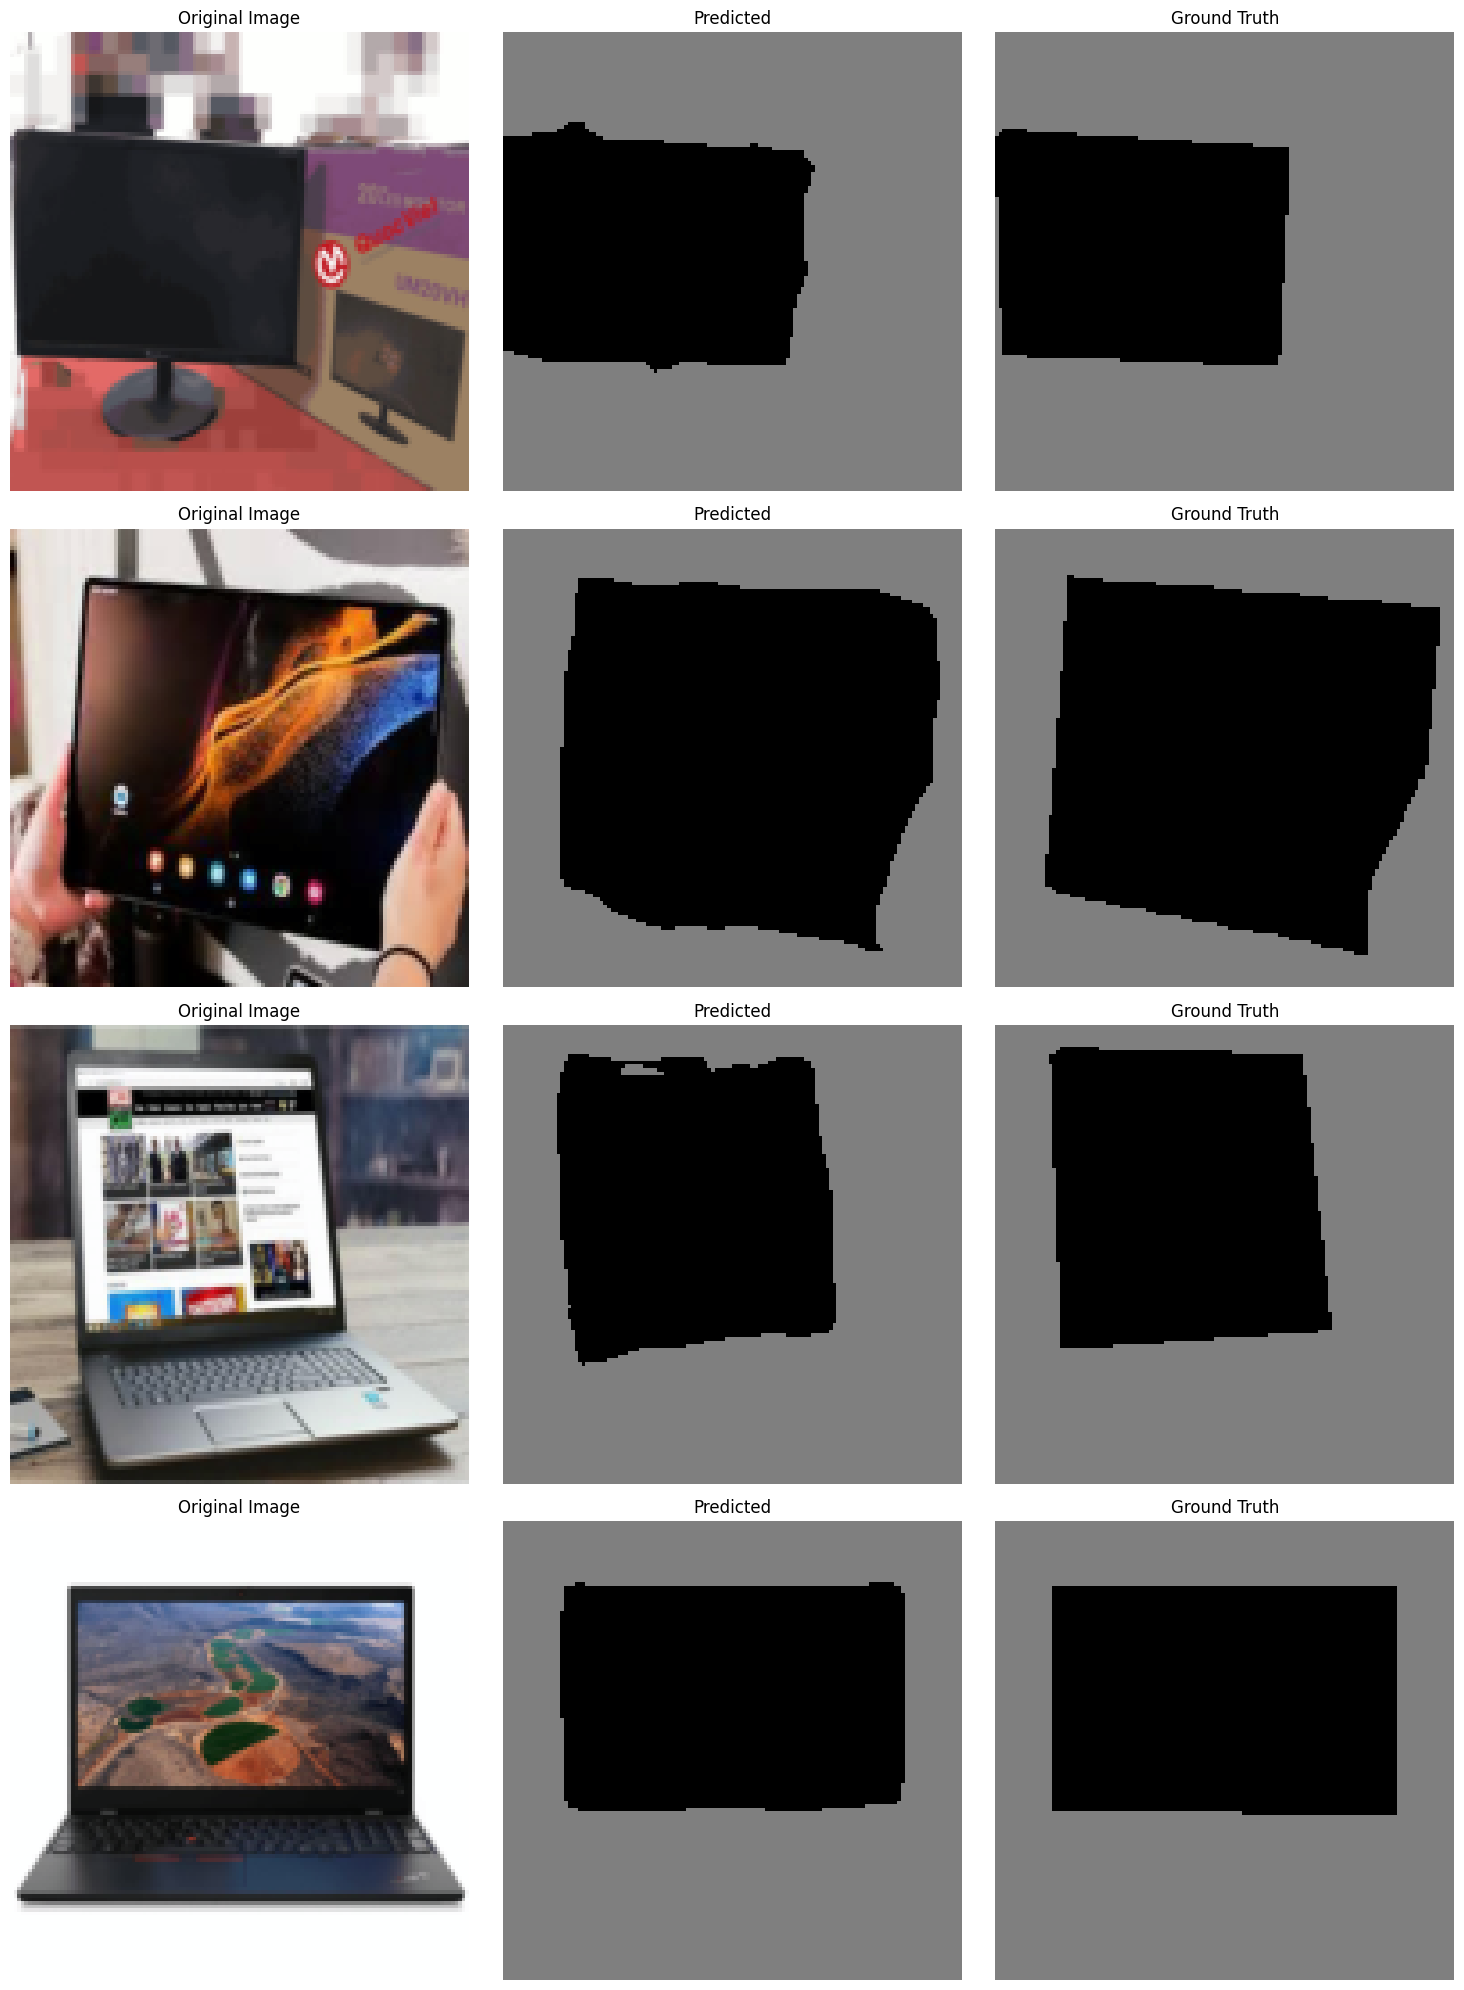

In [7]:
from matplotlib import pyplot as plt

color_map = {
    0: (0, 0, 0),
    1: (127, 127, 127),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i, c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

def tensor_to_image(tensor):
    """Преобразует тензор PyTorch [3, H, W] в изображение [H, W, 3] для отображения."""
    # Переводим тензор в NumPy, меняем порядок осей (C, H, W) -> (H, W, C)
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    # Денормализуем: feature_extractor нормализует пиксели в диапазон [0, 1] с mean и std,
    # возвращаем их в [0, 255]
    mean = np.array([0.485, 0.456, 0.406])  # Значения из ImageNet
    std = np.array([0.229, 0.224, 0.225])
    image = (image * std + mean) * 255  # Обратная нормализация
    image = np.clip(image, 0, 255).astype(np.uint8)
    return Image.fromarray(image)

# Визуализация предсказаний
segformer_finetuner.eval()
segformer_finetuner.to("cuda")
with torch.no_grad():
    for batch in test_dataloader:
        images, masks = batch['pixel_values'], batch['labels']
        images = images.to("cuda")
        masks = masks.to("cuda")
        outputs = segformer_finetuner.model(images, masks)
        loss, logits = outputs[0], outputs[1]
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        predicted = upsampled_logits.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()
        images = images.cpu()  # Переносим изображения обратно на CPU

        print("Predicted unique values:", np.unique(predicted))
        print("Mask unique values:", np.unique(masks))

        f, axarr = plt.subplots(4, 3, figsize=(15, 20))
        for i in range(4):
            # Исходное изображение
            original_image = tensor_to_image(images[i])
            axarr[i, 0].imshow(original_image)
            axarr[i, 0].set_title("Original Image")
            axarr[i, 0].axis("off")

            # Предсказанная маска
            pred_vis = prediction_to_vis(predicted[i, :, :])
            axarr[i, 1].imshow(pred_vis)
            axarr[i, 1].set_title("Predicted")
            axarr[i, 1].axis("off")

            # Истинная маска
            mask_vis = prediction_to_vis(masks[i, :, :])
            axarr[i, 2].imshow(mask_vis)
            axarr[i, 2].set_title("Ground Truth")
            axarr[i, 2].axis("off")
        plt.tight_layout()
        plt.show()
        break